In [22]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import pickle

import os 
import sys


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.feature_selection import SelectPercentile, chi2

#import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# import SGDRegressor
from sklearn.linear_model import SGDRegressor

In [23]:
data = 'Data/final_modeling.csv'

In [24]:
df = pd.read_csv(data)
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
0,15000,2013.0,ford,others,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black
1,27990,2012.0,gmc,others,good,8 cylinders,gas,68696.0,clean,other,4wd,truck,black
2,34590,2016.0,chevrolet,others,good,6 cylinders,gas,29499.0,clean,other,4wd,truck,silver
3,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey
4,29990,2016.0,chevrolet,others,good,6 cylinders,gas,17302.0,clean,other,4wd,truck,red


In [25]:
# count values where cylinders = other
df['manufacturer'].value_counts()

ford             18154
chevrolet        15634
others           13985
toyota            8933
honda             6064
nissan            5512
jeep              5138
gmc               4239
ram               3660
dodge             3436
bmw               2911
mercedes-benz     2591
subaru            2490
hyundai           2361
volkswagen        2193
lexus             2023
chrysler          1835
kia               1773
cadillac          1447
audi              1172
acura             1106
Name: manufacturer, dtype: int64

In [26]:
# drop cylinders = other
df = df[df['cylinders'] != 'other']

In [27]:
df = df[df['condition'] != 'salvage']

In [28]:
df = df[df['fuel'] != 'other']

In [29]:
df = df[df['manufacturer'] != 'others']

In [30]:
# df = df[df['model'] != 'others']

In [31]:
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
0,15000,2013.0,ford,others,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black
1,27990,2012.0,gmc,others,good,8 cylinders,gas,68696.0,clean,other,4wd,truck,black
2,34590,2016.0,chevrolet,others,good,6 cylinders,gas,29499.0,clean,other,4wd,truck,silver
3,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey
4,29990,2016.0,chevrolet,others,good,6 cylinders,gas,17302.0,clean,other,4wd,truck,red


In [32]:
# paint color, condition, Title Status

In [33]:
def age(df):
    df['age'] = 2021 - df['year']
    df.drop('year', axis=1, inplace=True)
    return df

In [34]:
df = age(df)


In [35]:
df.shape

(90982, 13)

In [36]:
df = df[df['age'] <= 25]

In [48]:
# apply boxcox transformation to price
# import powertransformer 
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = "box-cox")
pt.fit(df['price']).reshape(-1, 1)
df['price-1'] = pt.transform(df['price'])

ValueError: Expected 2D array, got 1D array instead:
array=[38590.  8600. 39000. ... 13850.  7995. 13988.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
df = df[df['price'] <= ]

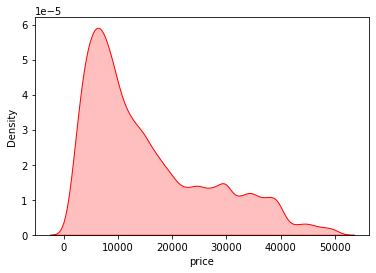

In [44]:
# kde plot of odometer
sns.kdeplot(df['price'], shade=True, color='r')
plt.show()

In [39]:
df.head()

,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
0,15000,ford,others,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,8.0
1,27990,gmc,others,good,8 cylinders,gas,68696.0,clean,other,4wd,truck,black,9.0
2,34590,chevrolet,others,good,6 cylinders,gas,29499.0,clean,other,4wd,truck,silver,5.0
3,35000,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,2.0
4,29990,chevrolet,others,good,6 cylinders,gas,17302.0,clean,other,4wd,truck,red,5.0


In [40]:
df.shape

(86532, 13)

In [41]:
# select random sample of 100000rows
df = df.sample(n=80000, random_state=42)



In [ ]:
# df = df.loc[:90000:,:]

In [42]:
numeric_features = ['odometer', 'age']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['manufacturer', 'model', 'fuel',\
                        'title_status', 'transmission', 'drive', 'type', 'paint_color']
categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder()), 
    ('selector', SelectPercentile(chi2, percentile=50))])

ordinal_features = ['condition', 'cylinders']
ordinal_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder()),
    ('selector', SelectPercentile(chi2, percentile=50))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # X_train = preprocessor.fit_transform(X_train)
# # X_test = preprocessor.transform(X_test)
# y_train = np.log(y_train)
# y_test = np.log(y_test)

# model 
Regressor = RandomForestRegressor(max_depth=50, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=1000)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', Regressor)])

# pipeline.fit(X_train, y_train)
from sklearn import set_config
set_config(display='diagram')
pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['odometer', 'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder()),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x28a2734c0>))]),
                                                  ['manufacturer', 'model',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color']),
                                                 ('ord',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder()),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x28a2734c0>))]),
                                                  ['condition',
                                                   'cylinders'])])),
                ('model',
                 RandomForestRegressor(max_depth=50, max_features=4,
                                       min_samples_leaf=3, min_samples_split=8,
                                       n_estimators=1000))])

In [43]:
pipeline.fit(X_train, y_train, model__sample_weight=y_train)
y_pred = pipeline.predict(X_test)

print('R2 score: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))

R2 score:  0.847541053706487
MAE:  2764.2225039739355


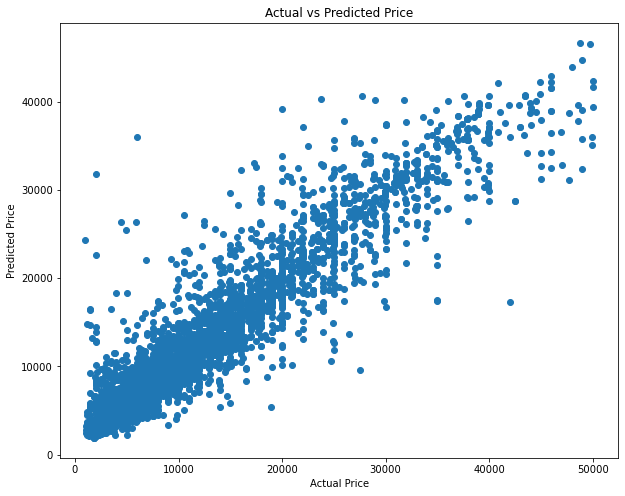

In [ ]:
# scatter plot of actual vs predicted values. Predictions in red and actual values in black.

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()


In [ ]:
# save the model to disk
filename = 'cars_model_tiny.pkl'
pickle.dump(pipeline, open(filename, 'wb'))

In [ ]:
# save predicted and actual values to dataframe
> df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_pred.head()

SyntaxError: invalid syntax (260571990.py, line 2)

In [ ]:
df_pred.to_csv('Data/df_pred.csv', index=False)

In [ ]:
# save the model to disk
filename = 'cars_model_f.pkl'
pickle.dump(pipeline, open(filename, 'wb'))

In [ ]:
X_tester = X_test.iloc[[112]]

In [ ]:
X_tester.head()

,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
81157,jeep,wrangler,excellent,4 cylinders,gas,127234.0,clean,manual,4wd,SUV,red,27.0


In [ ]:
{'manufacturer': 'ford',
 'model': 'f-150',
 'condition': 'good',
 'cylinders': '6 cylinders',
 'fuel': 'gas',
 'odometer': 100000,
 'title_status': 'clean',
 'transmission': 'automatic',
 'drive': '4wd',
 'type': 'truck',
 'paint_color': 'white',
 'age': 10}

{'manufacturer': 'ford',
 'model': 'f-150',
 'condition': 'good',
 'cylinders': '6 cylinders',
 'fuel': 'gas',
 'odometer': 100000,
 'title_status': 'clean',
 'transmission': 'automatic',
 'drive': '4wd',
 'type': 'truck',
 'paint_color': 'white',
 'age': 10}

In [ ]:
y_pred = pipeline.predict(X_tester)
print(y_pred)

[10755.17223777]


In [ ]:
y_test.iloc[[112]]

81157    7950
Name: price, dtype: int64

In [ ]:
testmodel = pickle.load(open('cars_model.pkl', 'rb'))

In [ ]:
y_pred = testmodel.predict(X_tester)
print(y_pred)

[6267.20219951]


In [ ]:
import requests
import json

In [ ]:
# testing 
url = 'http://127.0.0.1:5000/predictcar'

data = {"manufacturer": "ford",
 "model": "f-150",
 "condition": "good",
 "cylinders": "6 cylinders",
 "fuel": "gas",
 "odometer": 100000,
 "title_status": "clean",
 "transmission": "automatic",
 "drive": "4wd",
 "type": "truck",
 "paint_color": "white",
 "year": 2010}

import requests
res = requests.post(url, json= data)
if res.ok:
    print(res)
    print(res.json())
else:
    print(res)

<Response [200]>
['Your predicted market value is :', 17714.832555157063]


In [ ]:
string = "5000"

In [ ]:
int(string)

5000